<a href="https://colab.research.google.com/github/apple9855/DeepRL_byHuggingface/blob/main/Notebooks/bonus-unit1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bonus Unit 1: Let's train Huggy the Dog 🐶 to fetch a stick

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit2/thumbnail.png" alt="Bonus Unit 1Thumbnail">

In this notebook, we'll reinforce what we learned in the first Unit by **teaching Huggy the Dog to fetch the stick and then play with it directly in your browser**

⬇️ Here is an example of what **you will achieve at the end of the unit.** ⬇️ (launch ▶ to see)

In [ ]:
%%html
<video controls autoplay><source src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit-bonus1/huggy.mp4" type="video/mp4"></video>

### The environment 🎮

- Huggy the Dog, an environment created by [Thomas Simonini](https://twitter.com/ThomasSimonini) based on [Puppo The Corgi](https://blog.unity.com/technology/puppo-the-corgi-cuteness-overload-with-the-unity-ml-agents-toolkit)

### The library used 📚

- [MLAgents](https://github.com/Unity-Technologies/ml-agents)

We're constantly trying to improve our tutorials, so **if you find some issues in this notebook**, please [open an issue on the Github Repo](https://github.com/huggingface/deep-rl-class/issues).

## Objectives of this notebook 🏆

At the end of the notebook, you will:

- Understand **the state space, action space and reward function used to train Huggy**.
- **Train your own Huggy** to fetch the stick.
- Be able to play **with your trained Huggy directly in your browser**.




## This notebook is from Deep Reinforcement Learning Course
<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/deep-rl-course-illustration.jpg" alt="Deep RL Course illustration"/>

In this free course, you will:

- 📖 Study Deep Reinforcement Learning in **theory and practice**.
- 🧑‍💻 Learn to **use famous Deep RL libraries** such as Stable Baselines3, RL Baselines3 Zoo, CleanRL and Sample Factory 2.0.
- 🤖 Train **agents in unique environments**

And more check 📚 the syllabus 👉 https://simoninithomas.github.io/deep-rl-course

Don’t forget to **<a href="http://eepurl.com/ic5ZUD">sign up to the course</a>** (we are collecting your email to be able to **send you the links when each Unit is published and give you information about the challenges and updates).**


The best way to keep in touch is to join our discord server to exchange with the community and with us 👉🏻 https://discord.gg/ydHrjt3WP5

## Prerequisites 🏗️

Before diving into the notebook, you need to:

🔲 📚 **Develop an understanding of the foundations of Reinforcement learning** (MC, TD, Rewards hypothesis...) by doing Unit 1

🔲 📚 **Read the introduction to Huggy** by doing Bonus Unit 1

## Set the GPU 💪
- To **accelerate the agent's training, we'll use a GPU**. To do that, go to `Runtime > Change Runtime type`

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/gpu-step1.jpg" alt="GPU Step 1">

- `Hardware Accelerator > GPU`

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/gpu-step2.jpg" alt="GPU Step 2">

## Clone the repository and install the dependencies 🔽

- We need to clone the repository, that contains **ML-Agents.**

In [ ]:
%%capture
# Clone the repository (can take 3min)
!git clone --depth 1 https://github.com/Unity-Technologies/ml-agents

In [ ]:
%%capture
# Go inside the repository and install the package (can take 3min)
%cd ml-agents
!pip3 install -e ./ml-agents-envs
!pip3 install -e ./ml-agents

## Download and move the environment zip file in `./trained-envs-executables/linux/`

- Our environment executable is in a zip file.
- We need to download it and place it to `./trained-envs-executables/linux/`

In [ ]:
!mkdir ./trained-envs-executables
!mkdir ./trained-envs-executables/linux

We downloaded the file Huggy.zip from https://github.com/huggingface/Huggy using `wget`

In [ ]:
!wget "https://github.com/huggingface/Huggy/raw/main/Huggy.zip" -O ./trained-envs-executables/linux/Huggy.zip

In [ ]:
%%capture
!unzip -d ./trained-envs-executables/linux/ ./trained-envs-executables/linux/Huggy.zip

Make sure your file is accessible

In [ ]:
!chmod -R 755 ./trained-envs-executables/linux/Huggy

## Let's recap how this environment works

### The State Space: what Huggy "perceives."

Huggy doesn't "see" his environment. Instead, we provide him information about the environment:

- The target (stick) position
- The relative position between himself and the target
- The orientation of his legs.

Given all this information, Huggy **can decide which action to take next to fulfill his goal**.

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit-bonus1/huggy.jpg" alt="Huggy" width="100%">


### The Action Space: what moves Huggy can do
<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit-bonus1/huggy-action.jpg" alt="Huggy action" width="100%">

**Joint motors drive huggy legs**. It means that to get the target, Huggy needs to **learn to rotate the joint motors of each of his legs correctly so he can move**.

### The Reward Function

The reward function is designed so that **Huggy will fulfill his goal** : fetch the stick.

Remember that one of the foundations of Reinforcement Learning is the *reward hypothesis*: a goal can be described as the **maximization of the expected cumulative reward**.

Here, our goal is that Huggy **goes towards the stick but without spinning too much**. Hence, our reward function must translate this goal.

Our reward function:

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit-bonus1/reward.jpg" alt="Huggy reward function" width="100%">

- *Orientation bonus*: we **reward him for getting close to the target**.
- *Time penalty*: a fixed-time penalty given at every action to **force him to get to the stick as fast as possible**.
- *Rotation penalty*: we penalize Huggy if **he spins too much and turns too quickly**.
- *Getting to the target reward*: we reward Huggy for **reaching the target**.

## Create the Huggy config file

- In ML-Agents, you define the **training hyperparameters into config.yaml files.**

- For the scope of this notebook, we're not going to modify the hyperparameters, but if you want to try as an experiment, you should also try to modify some other hyperparameters, Unity provides very [good documentation explaining each of them here](https://github.com/Unity-Technologies/ml-agents/blob/main/docs/Training-Configuration-File.md).

- But we need to create a config file for Huggy.

  - To do that click on Folder logo on the left of your screen.

  <img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit1/create_file.png" alt="Create file" width="10%">

  - Go to `/content/ml-agents/config/ppo`
  - Right mouse click and create a new file called `Huggy.yaml`

  <img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit1/create-huggy.png" alt="Create huggy.yaml" width="20%">

- Copy and paste the content below 🔽

In [ ]:
behaviors:
  Huggy:
    trainer_type: ppo
    hyperparameters:
      batch_size: 2048
      buffer_size: 20480
      learning_rate: 0.0003
      beta: 0.005
      epsilon: 0.2
      lambd: 0.95
      num_epoch: 3
      learning_rate_schedule: linear
    network_settings:
      normalize: true
      hidden_units: 512
      num_layers: 3
      vis_encode_type: simple
    reward_signals:
      extrinsic:
        gamma: 0.995
        strength: 1.0
    checkpoint_interval: 200000
    keep_checkpoints: 15
    max_steps: 2e6
    time_horizon: 1000
    summary_freq: 50000

- Don't forget to save the file!

- **In the case you want to modify the hyperparameters**, in Google Colab notebook, you can click here to open the config.yaml: `/content/ml-agents/config/ppo/Huggy.yaml`

- For instance **if you want to save more models during the training** (for now, we save every 200,000 training timesteps). You need to modify:
  - `checkpoint_interval`: The number of training timesteps collected between each checkpoint.
  - `keep_checkpoints`: The maximum number of model checkpoints to keep.

=> Just keep in mind that **decreasing the `checkpoint_interval` means more models to upload to the Hub and so a longer uploading time**
We’re now ready to train our agent 🔥.

## Train our agent

To train our agent, we just need to **launch mlagents-learn and select the executable containing the environment.**

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit-bonus1/mllearn.png" alt="ml learn function" width="100%">

With ML Agents, we run a training script. We define four parameters:

1. `mlagents-learn <config>`: the path where the hyperparameter config file is.
2. `--env`: where the environment executable is.
3. `--run-id`: the name you want to give to your training run id.
4. `--no-graphics`: to not launch the visualization during the training.

Train the model and use the `--resume` flag to continue training in case of interruption.

> It will fail first time when you use `--resume`, try running the block again to bypass the error.



The training will take 30 to 45min depending on your machine (don't forget to **set up a GPU**), go take a ☕️you deserve it 🤗.

In [ ]:
!mlagents-learn ./config/ppo/Huggy.yaml --env=./trained-envs-executables/linux/Huggy/Huggy --run-id="Huggy2" --no-graphics

If above code occurs a bug. Here is a way to fix it. Find the "torch.py" and replace the code like this.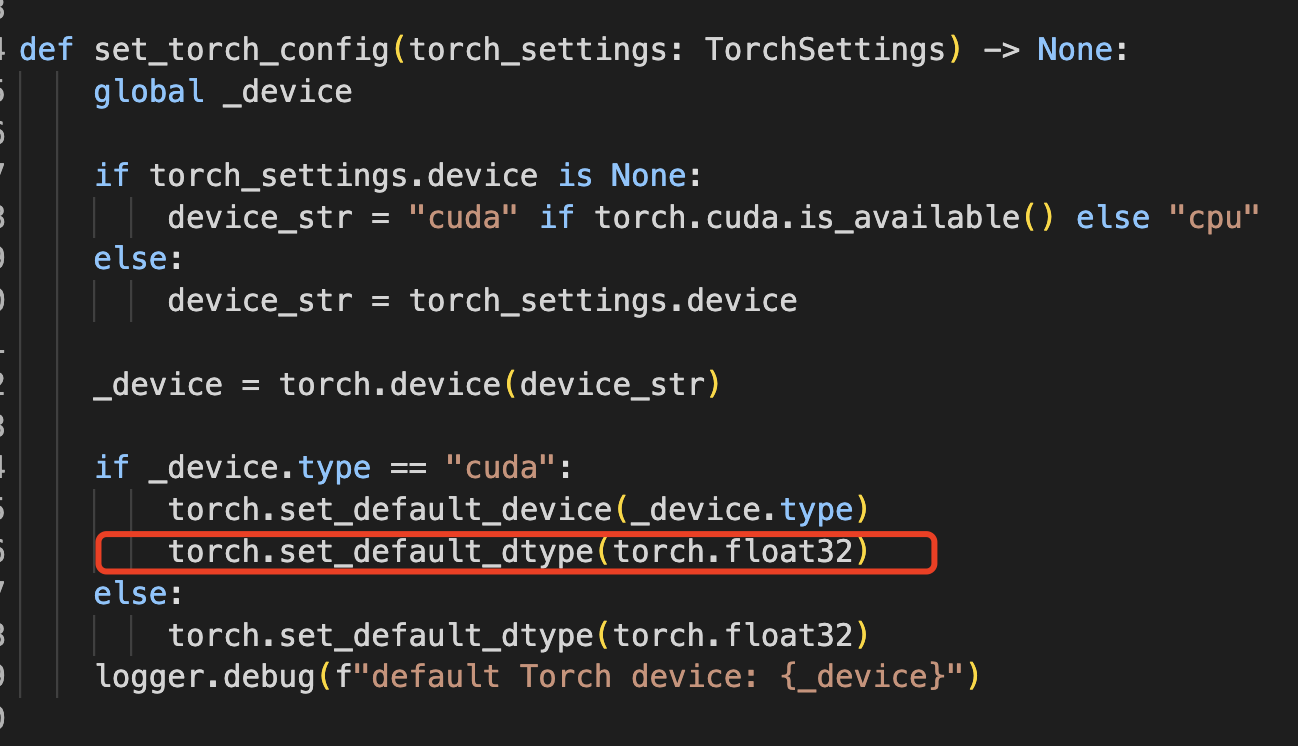


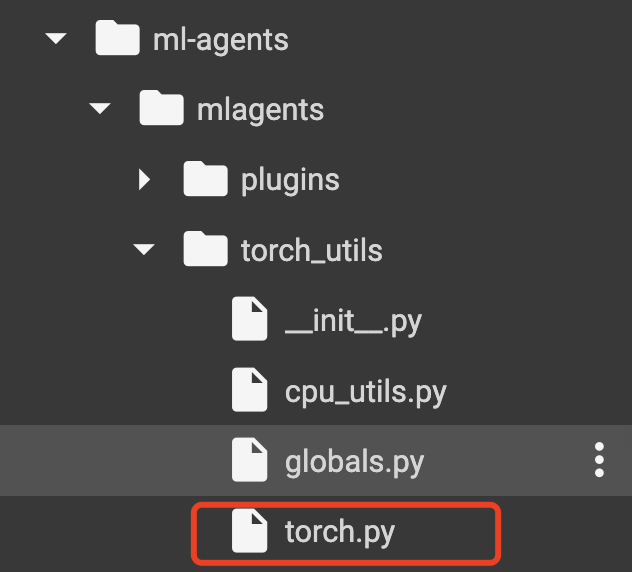


## Push the agent to the 🤗 Hub

- Now that we trained our agent, we’re **ready to push it to the Hub to be able to play with Huggy on your browser🔥.**

To be able to share your model with the community there are three more steps to follow:

1️⃣ (If it's not already done) create an account to HF ➡ https://huggingface.co/join

2️⃣ Sign in and then, you need to store your authentication token from the Hugging Face website.
- Create a new token (https://huggingface.co/settings/tokens) **with write role**

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/create-token.jpg" alt="Create HF Token">

- Copy the token
- Run the cell below and paste the token

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

If you don't want to use a Google Colab or a Jupyter Notebook, you need to use this command instead: `huggingface-cli login`

Then, we simply need to run `mlagents-push-to-hf`.

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit-bonus1/mlpush.png" alt="ml learn function" width="100%">

And we define 4 parameters:

1. `--run-id`: the name of the training run id.
2. `--local-dir`: where the agent was saved, it’s results/<run_id name>, so in my case results/First Training.
3. `--repo-id`: the name of the Hugging Face repo you want to create or update. It’s always <your huggingface username>/<the repo name>
If the repo does not exist **it will be created automatically**
4. `--commit-message`: since HF repos are git repository you need to define a commit message.

In [ ]:
!mlagents-push-to-hf --run-id="Huggy2" --local-dir="./results/Huggy2" --repo-id="apple9855/ppo-Huggy" --commit-message="Huggy"

Else, if everything worked you should have this at the end of the process(but with a different url 😆) :



```
Your model is pushed to the hub. You can view your model here: https://huggingface.co/ThomasSimonini/ppo-Huggy
```

It’s the link to your model repository. The repository contains a model card that explains how to use the model, your Tensorboard logs and your config file. **What’s awesome is that it’s a git repository, which means you can have different commits, update your repository with a new push, open Pull Requests, etc.**

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit-bonus1/modelcard.png" alt="ml learn function" width="100%">

But now comes the best: **being able to play with Huggy online 👀.**

## Play with your Huggy 🐕

This step is the simplest:

- Open the game Huggy in your browser: https://huggingface.co/spaces/ThomasSimonini/Huggy

- Click on Play with my Huggy model

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit-bonus1/load-huggy.jpg" alt="load-huggy" width="100%">

1. In step 1, type your username (your username is case sensitive: for instance, my username is ThomasSimonini not thomassimonini or ThOmasImoNInI) and click on the search button.
2. In step 2, select your model repository.
3. In step 3, **choose which model you want to replay**:  - I have multiple ones, since we saved a model every 500000 timesteps.
  - But since I want the more recent, I choose `Huggy.onnx`

👉 What’s nice **is to try with different models steps to see the improvement of the agent.**

Congrats on finishing this bonus unit!

You can now sit and enjoy playing with your Huggy 🐶. And don't **forget to spread the love by sharing Huggy with your friends 🤗**. And if you share about it on social media, **please tag us @huggingface and me @simoninithomas**

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit-bonus1/huggy-cover.jpeg" alt="Huggy cover" width="100%">


## Keep Learning, Stay  awesome 🤗